In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

In [14]:
# Load the dataset
df = pd.read_csv('ifood_df.csv')
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [15]:

# Split features and target variable
X = df.drop(columns=['Response'])
y = df['Response']

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [16]:
# Define hyperparameters grid for Grid Search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
}

classes = y.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=y)

# Create a dictionary of class weights
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

clf = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

In [17]:
#--------------------------------------------- BEST PAREMETERS ---------------------------------------------
#dot pltot
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
print(best_params)

data = {'Parameter': list(best_params.keys()), 'Value': list(best_params.values())}
df = pd.DataFrame(data)

# Define a function to add colors using pandas Styler
def highlight_params(val):
    color = '#BFE4FF' if val in best_params.keys() else '#D5FDDB' if str(val).isdigit() else '#FFFBBF'
    return f'background-color: {color}'

# Apply the function to the DataFrame using style
styled_df = df.style.applymap(highlight_params)

# Display the styled DataFrame
display(styled_df)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


,Parameter,Value
0,criterion,entropy
1,max_depth,None
2,min_samples_leaf,2
3,min_samples_split,2
4,splitter,best


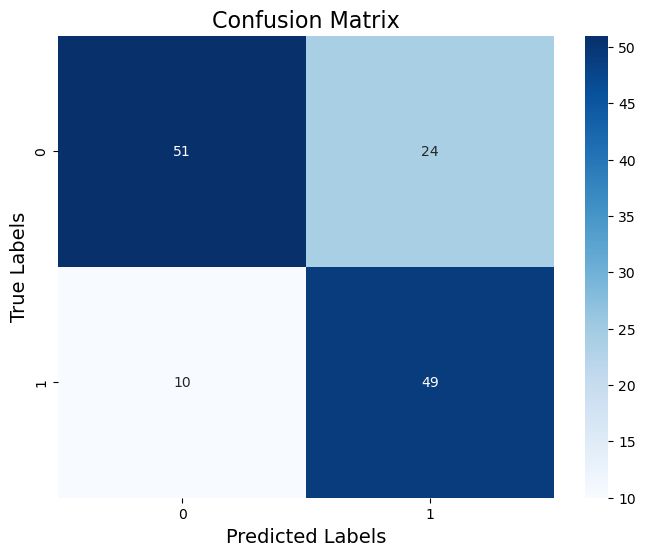

In [18]:
#--------------------------------------------- CONFUSION MATRIX ---------------------------------------------
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

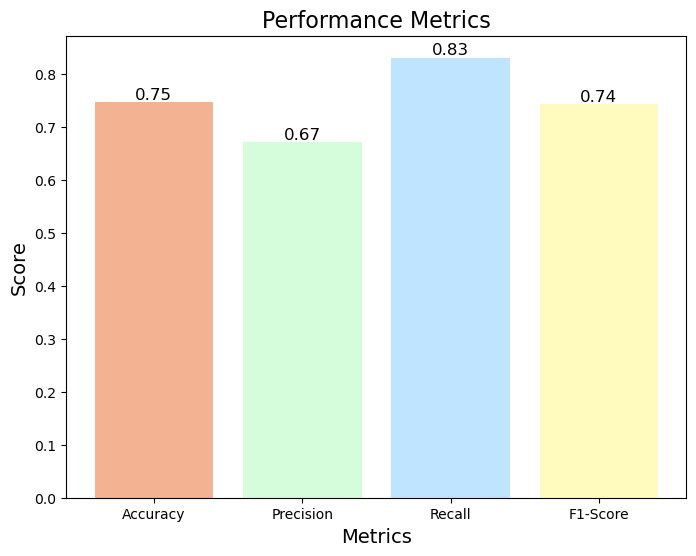

{'Accuracy': 0.746268656716418, 'Precision': 0.6712328767123288, 'Recall': 0.8305084745762712, 'F1-Score': 0.7424242424242425}


In [19]:
#--------------------------------------------- PERFORMANCE METRICS ---------------------------------------------
# Evaluate model performance

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

metrics = {'Accuracy': accuracy,
           'Precision': precision,
           'Recall': recall,
           'F1-Score': f1_score(y_test, y_pred)}

# Define colors for the bars
colors = ['#f3b393', '#D5FDDB', 
'#BFE4FF', '#FFFBBF']

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Performance Metrics', fontsize=16)

# Add exact numbers on top of each bar
for bar, value in zip(bars, metrics.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2), 
             ha='center', va='bottom', fontsize=12, color='black')
    
plt.show()
print(metrics)

In [20]:
#--------------------------------------------- FEATURE IMPORTANCE ---------------------------------------------
# Feature importance analysis
importances = best_clf.feature_importances_
print(importances)

# Print Feature Importance
feature_importance = pd.DataFrame(data={"features":X_test.columns, "importance":importances*100})
feature_importance.sort_values('importance', ascending=False).head(10).style.background_gradient(cmap='Blues', low=1, high=0)

[3.98528343e-02 2.45688794e-03 1.49289806e-02 1.82250539e-01
 1.86087644e-03 2.32166718e-02 5.91102026e-02 1.32653862e-02
 6.93791311e-03 6.10965060e-02 8.62800364e-03 2.60538621e-02
 5.69285523e-02 5.20272527e-02 1.09961751e-02 0.00000000e+00
 9.09854730e-03 3.93761039e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.23775746e-01
 1.25425773e-01 0.00000000e+00 0.00000000e+00 3.44728492e-03
 1.70369253e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.89867408e-03 2.13672196e-17 0.00000000e+00 1.85305984e-02
 1.34380730e-02 1.21800124e-01]


,features,importance
3,Recency,18.225054
24,Customer_Days,12.542577
23,Age,12.377575
37,AcceptedCmpOverall,12.180012
9,MntGoldProds,6.109651
6,MntMeatProducts,5.911020
12,NumCatalogPurchases,5.692855
13,NumStorePurchases,5.202725
0,Income,3.985283
11,NumWebPurchases,2.605386


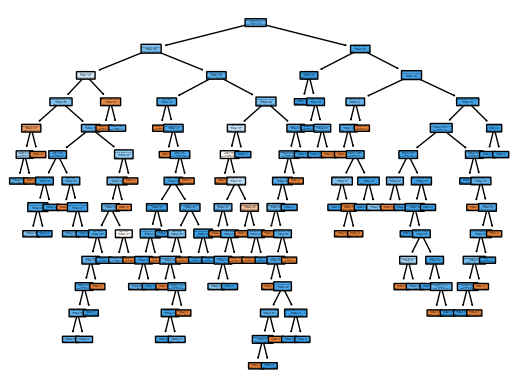

In [27]:
plt.figure()
plot_tree(best_clf, 
          feature_names=X.columns.tolist(), 
          class_names=["Response 0", "Response 1"], 
          filled=True, 
          rounded=True,) 
plt.savefig('decision_tree_high_res.png', dpi=500, bbox_inches='tight')
plt.show()

In [22]:
feature_names = X.columns.tolist()
tree_rules = export_text(best_clf, feature_names=feature_names)
print(tree_rules)

|--- AcceptedCmpOverall <= 0.50
|   |--- Customer_Days <= 2524.00
|   |   |--- Recency <= 42.50
|   |   |   |--- NumCatalogPurchases <= 0.50
|   |   |   |   |--- MntRegularProds <= 11.50
|   |   |   |   |   |--- Teenhome <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Teenhome >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- MntRegularProds >  11.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- NumCatalogPurchases >  0.50
|   |   |   |   |--- Recency <= 12.50
|   |   |   |   |   |--- Age <= 50.50
|   |   |   |   |   |   |--- MntGoldProds <= 18.00
|   |   |   |   |   |   |   |--- Customer_Days <= 2411.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Customer_Days >  2411.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- MntGoldProds >  18.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Age >  50.50
|   |   |   |   |   |   |--- Age <= 60.50
|   |   |   |   |   